### Revision de cambio entre la distribución de la data de muestra y la data de entrenamiento

In [1]:
import polars as pl
import matplotlib.pyplot as plt

In [2]:
df_sample = pl.read_csv("data/train_sample.csv", try_parse_dates=True)
df_train = pl.read_csv("data/train.csv", try_parse_dates=True)

In [3]:
df_sample.head()

ip,app,device,os,channel,click_time,attributed_time,is_attributed
i64,i64,i64,i64,i64,datetime[μs],str,i64
87540,12,1,13,497,2017-11-07 09:30:38,null,0
105560,25,1,17,259,2017-11-07 13:40:27,null,0
101424,12,1,19,212,2017-11-07 18:05:24,null,0
94584,13,1,13,477,2017-11-07 04:58:08,null,0
68413,12,1,1,178,2017-11-09 09:00:09,null,0


In [4]:
# df_sample.schema["click_time"]

#### 1. Revisar fechas inicial y final en ambos datasets

In [5]:
df_train = df_train.with_columns(
    pl.col("click_time").dt.date().alias("fecha")
)
df_sample = df_sample.with_columns(
    pl.col("click_time").dt.date().alias("fecha")
)

# Rango de fechas en train
rango_train = df_train.select(
    pl.col("fecha").min().alias("fecha_inicial_train"),
    pl.col("fecha").max().alias("fecha_final_train")
)

# Rango de fechas en sample
rango_sample = df_sample.select(
    pl.col("fecha").min().alias("fecha_inicial_sample"),
    pl.col("fecha").max().alias("fecha_final_sample")
)

# Extraer valores para imprimir
fila_train = rango_train.row(0)
fecha_inicial_train = fila_train[0]
fecha_final_train = fila_train[1]

fila_sample = rango_sample.row(0)
fecha_inicial_sample = fila_sample[0]
fecha_final_sample = fila_sample[1]

print("Train  → desde:", fecha_inicial_train, "hasta:", fecha_final_train)
print("Sample → desde:", fecha_inicial_sample, "hasta:", fecha_final_sample)

Train  → desde: 2017-11-06 hasta: 2017-11-09
Sample → desde: 2017-11-06 hasta: 2017-11-09


#### 2. Cobertura temporal (drift por hora)

In [6]:
df_sample = df_sample.with_columns(
        pl.col("click_time").dt.hour().alias("hora"),
        pl.col("click_time").dt.date().alias("fecha"),
    )
df_train = df_train.with_columns(
        pl.col("click_time").dt.hour().alias("hora"),
        pl.col("click_time").dt.date().alias("fecha"),
    )

In [7]:
# print(df_sample.select("click_time", "hora", "fecha").head())

In [8]:
total_train_horas = df_train.height
total_sample_horas = df_sample.height

conteo_por_hora_train = (
    df_train
    .group_by("hora")
    .agg(pl.len().alias("conteo_train"))
    .sort("hora")
)

conteo_por_hora_sample = (
    df_sample
    .group_by("hora")
    .agg(pl.len().alias("conteo_sample"))
    .sort("hora")
)

In [9]:
perfil_por_hora = (
    conteo_por_hora_train
    .join(conteo_por_hora_sample, on="hora", how="full", coalesce=True)
    .with_columns(
        pl.col("conteo_train").fill_null(0),
        pl.col("conteo_sample").fill_null(0)
    )
    .with_columns(
        (pl.col("conteo_train") * 100.0 / float(total_train_horas)).alias("porcentaje_train"),
        (pl.col("conteo_sample") * 100.0 / float(total_sample_horas)).alias("porcentaje_sample")
    )
    .with_columns(
        (pl.col("porcentaje_sample") - pl.col("porcentaje_train")).alias("diferencia_pp"),
        (pl.col("porcentaje_sample") - pl.col("porcentaje_train")).abs().alias("diferencia_pp_absoluta")
    )
    .select(
        "hora",
        "conteo_train",
        "conteo_sample",
        "porcentaje_train",
        "porcentaje_sample",
        "diferencia_pp",
        "diferencia_pp_absoluta"
    )
    .sort("hora")
)

In [10]:
perfil_por_hora

hora,conteo_train,conteo_sample,porcentaje_train,porcentaje_sample,diferencia_pp,diferencia_pp_absoluta
i8,u32,u32,f64,f64,f64,f64
0,10416435,5654,5.633432,5.654,0.020568,0.020568
1,9456661,5103,5.114366,5.103,-0.011366,0.011366
2,9750363,5137,5.273206,5.137,-0.136206,0.136206
3,9743476,5264,5.269481,5.264,-0.005481,0.005481
4,11223316,6039,6.069811,6.039,-0.030811,0.030811
…,…,…,…,…,…,…
19,1543463,870,0.834738,0.87,0.035262,0.035262
20,1266331,699,0.684859,0.699,0.014141,0.014141
21,1578956,864,0.853933,0.864,0.010067,0.010067


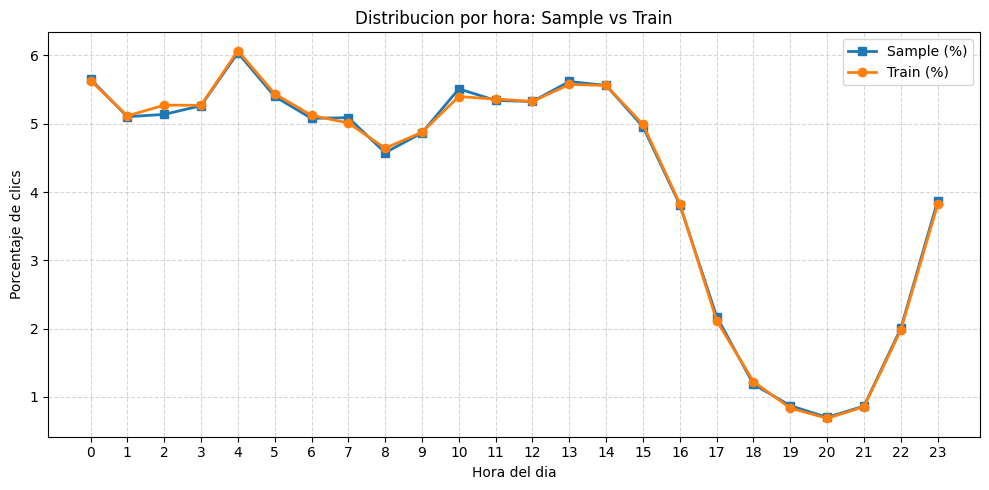

In [11]:
horas = perfil_por_hora.select("hora").to_series().to_list()
porcentaje_sample = perfil_por_hora.select("porcentaje_sample").to_series().to_list()
porcentaje_train = perfil_por_hora.select("porcentaje_train").to_series().to_list()

plt.figure(figsize=(10, 5))
plt.plot(horas, porcentaje_sample, marker="s", linewidth=2, label="Sample (%)")
plt.plot(horas, porcentaje_train, marker="o", linewidth=2, label="Train (%)")
plt.title("Distribucion por hora: Sample vs Train")
plt.xlabel("Hora del dia")
plt.ylabel("Porcentaje de clics")
plt.xticks(range(0, 24))
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

No se observa drift horario relevante debido a que las curvas casi se superponen completamente.

#### 3. Cobertura temporal (drift por dia)

In [12]:
total_train_dias = df_train.height
total_sample_dias = df_sample.height

conteo_por_dia_train = (
    df_train
    .group_by("fecha")
    .agg(pl.len().alias("conteo_train"))
    .sort("fecha")
)

conteo_por_dia_sample = (
    df_sample
    .group_by("fecha")
    .agg(pl.len().alias("conteo_sample"))
    .sort("fecha")
)

perfil_por_dia = (
    conteo_por_dia_train
    .join(conteo_por_dia_sample, on="fecha", how="full", coalesce=True)
    .with_columns(
        pl.col("conteo_train").fill_null(0),
        pl.col("conteo_sample").fill_null(0)
    )
    .with_columns(
        (pl.col("conteo_train") * 100.0 / float(total_train_dias)).alias("porcentaje_train"),
        (pl.col("conteo_sample") * 100.0 / float(total_sample_dias)).alias("porcentaje_sample")
    )
    .with_columns(
        (pl.col("porcentaje_sample") - pl.col("porcentaje_train")).alias("diferencia_pp"),
        (pl.col("porcentaje_sample") - pl.col("porcentaje_train")).abs().alias("diferencia_pp_absoluta")
    )
    .select(
        "fecha",
        "conteo_train",
        "conteo_sample",
        "porcentaje_train",
        "porcentaje_sample",
        "diferencia_pp",
        "diferencia_pp_absoluta"
    )
    .sort("fecha")
)
perfil_por_dia 

fecha,conteo_train,conteo_sample,porcentaje_train,porcentaje_sample,diferencia_pp,diferencia_pp_absoluta
date,u32,u32,f64,f64,f64,f64
2017-11-06,9308568,5011,5.034274,5.011,-0.023274,0.023274
2017-11-07,59633310,32393,32.250976,32.393,0.142024,0.142024
2017-11-08,62945075,34035,34.04205,34.035,-0.00705,0.00705
2017-11-09,53016937,28561,28.6727,28.561,-0.1117,0.1117


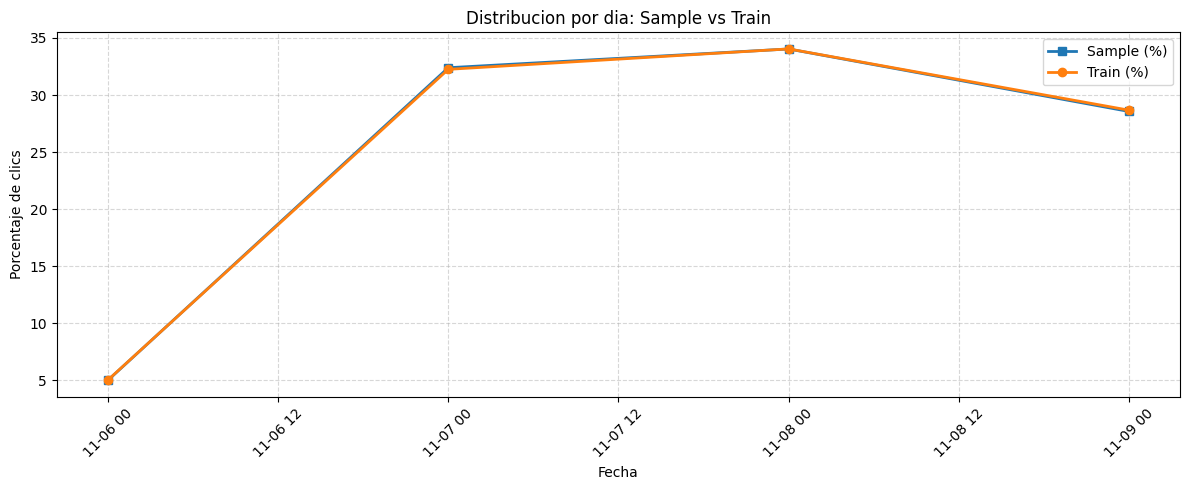

In [13]:
fechas = perfil_por_dia.select("fecha").to_series().to_list()
porcentaje_train_dia = perfil_por_dia.select("porcentaje_train").to_series().to_list()
porcentaje_sample_dia = perfil_por_dia.select("porcentaje_sample").to_series().to_list()

plt.figure(figsize=(12, 5))
plt.plot(fechas, porcentaje_sample_dia, marker="s", linewidth=2, label="Sample (%)")
plt.plot(fechas, porcentaje_train_dia, marker="o", linewidth=2, label="Train (%)")
plt.title("Distribucion por dia: Sample vs Train")
plt.xlabel("Fecha")
plt.ylabel("Porcentaje de clics")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Al igual que con las horas, no se observa un cambio relevante en el periodo de la data de muestra versus la data de entrenamientdebido a que las curvas se superponen casi completamente.

#### 4. Prevalencia del target

In [14]:
global_train = (
    df_train
    .select(
        pl.len().alias("total_train"),
        pl.col("is_attributed").sum().alias("positivos_train")
    )
    .with_columns(
        (pl.col("positivos_train") * 100.0 / pl.col("total_train")).alias("prevalencia_train_pct")
    )
)

global_sample = (
    df_sample
    .select(
        pl.len().alias("total_sample"),
        pl.col("is_attributed").sum().alias("positivos_sample")
    )
    .with_columns(
        (pl.col("positivos_sample") * 100.0 / pl.col("total_sample")).alias("prevalencia_sample_pct")
    )
)

fila_global_train = global_train.row(0)
fila_global_sample = global_sample.row(0)

total_train_global = fila_global_train[0]
positivos_train_global = fila_global_train[1]
prevalencia_train_global = fila_global_train[2]

total_sample_global = fila_global_sample[0]
positivos_sample_global = fila_global_sample[1]
prevalencia_sample_global = fila_global_sample[2]

print("Train total:", total_train_global, "positivos:", positivos_train_global, "prevalencia %:", float(prevalencia_train_global))
print("Sample total:", total_sample_global, "positivos:", positivos_sample_global, "prevalencia %:", float(prevalencia_sample_global))


Train total: 184903890 positivos: 456846 prevalencia %: 0.2470721410998979
Sample total: 100000 positivos: 227 prevalencia %: 0.227


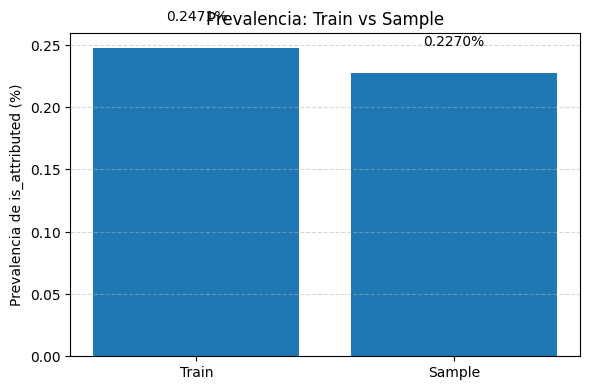

In [15]:
etiquetas = ["Train", "Sample"]

prevalencias = [float(prevalencia_train_global), float(prevalencia_sample_global)]

posiciones = [0, 1]

plt.figure(figsize=(6, 4))
plt.bar(posiciones, prevalencias)
plt.xticks(posiciones, etiquetas)
plt.ylabel("Prevalencia de is_attributed (%)")
plt.title("Prevalencia: Train vs Sample")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)

indice = 0
while indice < len(posiciones):
    valor = prevalencias[indice]
    plt.text(posiciones[indice], valor + 0.02, f"{valor:.4f}%", ha="center", va="bottom")
    indice = indice + 1

plt.tight_layout()
plt.show()

0.247% se encuentra bastante cercano a 0.227%n por lo tanto, no existe evidencia de drift global de la variable objetivo.